In [26]:
from jetnet_dataloader import JetNetDataloader,StandardScaler, QuantileTransformer
# from helpers import mass
from plotting import *
    
hpconfig = {
        "context_features": 1,
        "network_layers_nf": 2,
        "network_nodes_nf": 256,
        "batch_size": 4024,#1024 best
        "coupling_layers": 8,
        "lr": 0.001,
        "batchnorm": True,
        "bins": 5,
        "tail_bound": 6,
        "limit": 200000,
        "n_dim": 3,
        "dropout": 0.1,
        "canonical": False,
        "max_steps": 100000,
        "name": "Transflow_notebook",
        "parton": "t",
        "num_layers": 4,
        "freq": 1,
        "n_part": 15,
        "fc": False,
        "hidden": 250,
        "heads": 5,
        "l_dim": 50,
        "lr_g": 0.001,
        "lr_d": 0.001,
        "lr_nf": 0.000722,
        "sched":  "cosine",
        "opt": "Adam",
        "max_epochs": 800,
        "mass": True,
        "no_hidden": True,
        "clf": True,
        "val_check": 10,
        "frac_pretrain": 40,
        "seed": 69,
        "quantile": False,
        "norm":False
    }

In [69]:

from distutils.command.config import config
import os
import time
import traceback

import matplotlib.pyplot as plt
import nflows as nf
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import torch
from jetnet.evaluation import cov_mmd, fpnd, w1efp, w1m, w1p
from nflows.flows import base
from nflows.nn import nets
from nflows.transforms.base import CompositeTransform
from nflows.transforms.coupling import PiecewiseRationalQuadraticCouplingTransform
from nflows.utils.torchutils import create_random_binary_mask
from torch import nn
from torch.nn import functional as FF
from torch.nn.functional import leaky_relu, sigmoid
from torch.autograd import Variable
import torch.autograd as autograd

from helpers import CosineWarmupScheduler, mass
from plotting import *


class Gen(nn.Module):
    def __init__(
        self,
        n_dim=3,
        l_dim=10,
        hidden=300,
        num_layers=3,
        num_heads=1,
        n_part=5,
        fc=False,
        dropout=0.5,
        no_hidden=True,
        norm=False
    ):

        super().__init__()
        self.hidden_nodes = hidden
        self.n_dim = n_dim
        self.l_dim = l_dim
        self.n_part = n_part
        self.no_hidden = no_hidden
        self.fc = fc
        if fc:
            self.l_dim *= n_part
            self.embbed_flat = nn.Linear(n_dim * n_part, l_dim)
            self.flat_hidden = nn.Linear(l_dim, hidden)
            self.flat_hidden2 = nn.Linear(hidden, hidden)
            self.flat_hidden3 = nn.Linear(hidden, hidden)
            self.flat_out = nn.Linear(hidden, n_dim * n_part)
            self.out = nn.Linear(hidden, n_dim)
            
        else:
            self.embbed = nn.Linear(n_dim, l_dim)
            self.encoder = nn.TransformerEncoder(
                nn.TransformerEncoderLayer(
                    d_model=l_dim,
                    nhead=num_heads,
                    batch_first=True,
                    norm_first=norm,
                    dim_feedforward=hidden,
                    dropout=dropout,
                ),
                num_layers=num_layers,
            )
            self.hidden = nn.Linear(l_dim, hidden)
            self.hidden2 = nn.Linear(hidden, hidden)
            self.hidden3 = nn.Linear(hidden, hidden)
            self.dropout = nn.Dropout(dropout / 2)
            self.out = nn.Linear(hidden, n_dim)
            self.out2 = nn.Linear(l_dim, n_dim)

            self.out_flat = nn.Linear(hidden, n_dim * n_part)

    def forward(self, x, mask=None):

        if self.fc:
            x = x.reshape(len(x), self.n_part * self.n_dim)
            x = self.embbed_flat(x)
            x = leaky_relu(self.flat_hidden(x))
            #             x = self.dropout(x)
            x = self.flat_out(x)
            x = x.reshape(len(x), self.n_part, self.n_dim)
        else:
            x = self.embbed(x)
            x = self.encoder(x, src_key_padding_mask=mask)
            if not self.no_hidden == True:
                x = leaky_relu(self.hidden(x))
                x = self.dropout(x)
                x = leaky_relu(self.hidden2(x))
                x = self.dropout(x)
                x = self.out(x)
            elif self.no_hidden == "more":
                x = leaky_relu(self.hidden(x))
                x = self.dropout(x)
                x = leaky_relu(self.hidden2(x))
                x = self.dropout(x)
                x = leaky_relu(self.hidden3(x))
                x = self.dropout(x)

            else:
                x = leaky_relu(x)
                x = self.out2(x)
        return x


class Disc(nn.Module):
    def __init__(
        self,
        n_dim=3,
        l_dim=10,
        hidden=300,
        num_layers=3,
        num_heads=1,
        n_part=2,
        fc=False,
        dropout=0.5,
        mass=False,
        clf=False,
        norm=False,
        no_hidden=True
    ):
        super().__init__()
        self.hidden_nodes = hidden
        self.n_dim = n_dim
        #         l_dim=n_dim
        self.l_dim = l_dim
        self.n_part = n_part
        self.fc = fc
        self.clf = clf
        self.no_hidden = no_hidden
        self.sig=nn.Sigmoid()
        self.use_mass=mass
        self.bullshitbingo=False
        self.layernorm=nn.LayerNorm(l_dim+mass)
        if fc:
            self.l_dim *= n_part
            self.embbed_flat = nn.Linear(n_dim * n_part, l_dim)
            self.flat_hidden = nn.Linear(l_dim, hidden)
            self.flat_hidden2 = nn.Linear(hidden, hidden)
            self.flat_hidden3 = nn.Linear(hidden, hidden)
            self.out = nn.Linear(hidden, 1)
        else:
            self.embbed=nn.Linear(n_dim,l_dim)
            self.encoder=nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=self.l_dim,nhead=num_heads,dim_feedforward=hidden,dropout=dropout,
                                       norm_first=norm,activation=lambda x: leaky_relu(x,0.2),batch_first=True) ,num_layers=num_layers)
            self.hidden=nn.Linear(l_dim+int(mass)-self.bullshitbingo,hidden)
            self.hidden2=nn.Linear(hidden,hidden)
            self.out=nn.Linear(hidden if not no_hidden else l_dim+mass,1)
    
    def forward(self, x, m=None, mask=None):
        if self.fc == True:
            x = x.reshape(len(x), self.n_dim * self.n_part)
            x = self.embbed_flat(x)
            x = leaky_relu(self.flat_hidden(x), 0.2)
            x = leaky_relu(self.flat_hidden2(x), 0.2)
#         elif self.bullshitbingo:
#             x = torch.cat((m.repeat(3,1).reshape(len(m),1,3),x),axis=1)
#             x = self.embbed(x)
#             x = self.encoder(x)
#             if self.clf:
#                 x=torch.concat((torch.ones_like(x[:,0,:]).reshape(len(x),1,-1),x),axis=1)
#                 x=self.encoder(x)
#                 x=x[:,0,:]
#             else:
#                 x=self.encoder(x)
#                 x=torch.mean(x,axis=1)
#             if not self.no_hidden:
#                 x=leaky_relu(self.hidden(x),0.2)
#                 x=leaky_relu(self.hidden2(x),0.2)
#             x=self.out(x)
# #             x=self.sig(x)
        else:
            x = self.embbed(x)
            if self.clf:   
                x=torch.concat((torch.ones_like(x[:,0,:]).reshape(len(x),1,-1),x),axis=1)
                x=self.encoder(x)
                x=x[:,0,:]
            else:
                x=self.encoder(x)
                x=torch.mean(x,axis=1)
            if self.use_mass:
                x=torch.concat((m.reshape(len(x),1),x),axis=1)
                
            if not self.no_hidden:
                x=leaky_relu(self.hidden(x),0.2)
#                 x=self.layernorm(x)
#                 x=leaky_relu(self.hidden2(x),0.2)
        x=self.out(x)
#             x=self.sig(x)
        return x

def mass(data, mask=None, canonical=False):
    if len(data.shape)==2:
        if not mask==None:
            data = data.reshape(len(data),data.shape[1]//3, 3) * mask.reshape(len(data), data.shape[1]//3, 1)
        else:
            data = data.reshape(len(data),data.shape[1]//3, 3)
    if canonical:        
        p = data
        px = p[:, :, 0]
        py = p[:, :, 1]
        pz = p[:, :, 2]
    else: 
        p = data
        px = torch.cos(p[:, :, 1]) * p[:, :, 2]
        py = torch.sin(p[:, :, 1]) * p[:, :, 2]
        pz = torch.sinh(p[:, :, 0]) * p[:, :, 2]
    
    E = torch.sqrt(px**2 + py**2 + pz**2)
    E = E.sum(axis=1) ** 2
    p = px.sum(axis=1) ** 2 + py.sum(axis=1) ** 2 + pz.sum(axis=1) ** 2
    m2 = E - p
    return torch.sqrt(m2)
class TransGan(pl.LightningModule):
    def create_resnet(self, in_features, out_features):
        """This is the network that outputs the parameters of the invertible transformation
        The only arguments can be the in dimension and the out dimenson, the structure
        of the network is defined over the config which is a class attribute
        Context Features: Amount of features used to condition the flow - in our case
        this is usually the mass
        num_blocks: How many Resnet blocks should be used, one res net block is are 1 input+ 2 layers
        and an additive skip connection from the first to the third"""
        c = self.config["context_features"]
        return nets.ResidualNet(
            in_features,
            out_features,
            hidden_features=self.config["network_nodes_nf"],
            context_features=c,
            num_blocks=self.config["network_layers_nf"],
            activation=self.config["activation"] if "activation" in self.config.keys() else FF.relu,
            dropout_probability=self.config["dropout"] if "dropout" in self.config.keys() else 0,
            use_batch_norm=self.config["batchnorm"] if "batchnorm" in self.config.keys() else 0,
        )

    def __init__(self, config, hyperopt, num_batches):
        """This initializes the model and its hyperparameters"""
        super().__init__()
        self.hyperopt = True

        self.start = time.time()
        # self.batch_size=batch_size
        # print(batch_size)
        self.config = config
        self.automatic_optimization = False
        self.freq_d = config["freq"]

#         self.wgan = config["wgan"]
        # Metrics to track during the training
        self.metrics = {
            "val_w1p": [],
            "val_w1m": [],
            "val_w1efp": [],
            "val_cov": [],
            "val_mmd": [],
            "val_fpnd": [],
            "val_logprob": [],
            "step": [],
        }
        # Loss function of the Normalizing flows
        self.logprobs = []
        self.n_part = config["n_part"]
        # self.hparams.update(config)
        self.save_hyperparameters()
        self.flows = []
        self.n_dim = self.config["n_dim"]
        self.n_part = config["n_part"]
        self.alpha = 1
        self.num_batches = int(num_batches)
        self.build_flow()
        self.gen_net = Gen(
            n_dim=self.n_dim,
            hidden=config["hidden"],
            num_layers=config["num_layers"],
            dropout=config["dropout"],
            no_hidden=config["no_hidden"],
            fc=config["fc"],
            n_part=config["n_part"],
            l_dim=config["l_dim"],
            num_heads=config["heads"],
            norm=config["norm"]
        ).cuda()
        self.dis_net = Disc(
            n_dim=self.n_dim,
            hidden=config["hidden"],
            l_dim=config["l_dim"],
            num_layers=config["num_layers"],
            mass=self.config["mass"],
            num_heads=config["heads"],
            fc=config["fc"],
            n_part=config["n_part"],
            dropout=config["dropout"],
            clf=config["clf"],
            no_hidden=config["no_hidden"],
            norm=config["norm"],
            
        ).cuda()
        self.sig = nn.Sigmoid()
        self.fpnds = []
        self.df = pd.DataFrame()
        for p in self.dis_net.parameters():
            if p.dim() > 1:
                nn.init.xavier_normal_(p)
        for p in self.gen_net.parameters():
            if p.dim() > 1:
                nn.init.xavier_normal_(p)
        self.gen_net.out.weight.data.fill_(0)#uniform_(-0.01,0.01)
        self.gen_net.out.bias.data.fill_(0)
        self.nf_train = True
        self.train_nf = config["max_epochs"] // config["frac_pretrain"]

    def load_datamodule(self, data_module):
        """needed for lightning training to work, it just sets the dataloader for training and validation"""
        self.data_module = data_module
    
    def plot_mass(self,m_f,m_t=None,postfix=""):
        fig=plt.figure()
        
        m_f=m_f.cpu().detach().numpy()
        if not m_t==None:
            m_t=m_t.cpu().detach().numpy()
            max_m=np.min([np.quantile(m_t,0.95),np.quantile(m_f,0.95)])
            _,bins,_=plt.hist(m_t,bins=np.linspace(0,max_m,30),label="True",histtype="step")
#             _,bins,_=plt.hist(m_t.cpu().detach().numpy(),bins=30,label="True",histtype="step")
            plt.hist(m_f,bins=bins,label="Fake",histtype="step")
        else:
            
            plt.hist(m_f[m_f<500],bins=30,label="Gen",histtype="step")
        plt.legend()
        plt.ylabel("Counts")
        plt.xlabel("Critic Score")
        self.logger.experiment.add_figure("train_mass"+postfix, fig, global_step=self.current_epoch)
        plt.close()
    
    def plot_class(self,pred_real,pred_fake,mask):
        fig, ax = plt.subplots()
        ax.hist(pred_real.detach().cpu().numpy(), label="real", bins=30, histtype="step",density=1)
        ax.hist(pred_fake.detach().cpu().numpy(), label="fake", bins=30, histtype="step",density=1)
#         ax.hist(pred_real[mask.sum(1)].detach().cpu().numpy(), label="real<30", bins=np.linspace(0, 1, 30) if not self.wgan else 30, histtype="step",density=1)
#         ax.hist(pred_fake[mask.sum(1)].detach().cpu().numpy(), label="fake<30", bins=np.linspace(0, 1, 30) if not self.wgan else 30, histtype="step",density=1)
        ax.legend()
        plt.ylabel("Counts")
        plt.xlabel("Critic Score")
        self.logger.experiment.add_figure("class_train", fig, global_step=self.current_epoch)
        plt.close()

    def on_after_backward(self) -> None:
        """This is a genious little hook, sometimes my model dies, i have no clue why. This saves the training from crashing and continues"""
        valid_gradients = False
        for name, param in self.named_parameters():
            if param.grad is not None:
                valid_gradients = not (torch.isnan(param.grad).any() or torch.isinf(param.grad).any())
                if not valid_gradients:
                    break
        if not valid_gradients:
            
            self.zero_grad()
            self.counter += 1
            if self.counter > 8:
                raise ValueError("5 nangrads in a row")
        else:
            self.counter = 0

    def build_flow(self):
        K = self.config["coupling_layers"]
        for i in range(K):
            """This creates the masks for the coupling layers, particle masks are masks
            created such that each feature particle (eta,phi,pt) is masked together or not"""
            mask = create_random_binary_mask(self.n_dim * self.n_part)
            self.flows += [
                PiecewiseRationalQuadraticCouplingTransform(
                    mask=mask,
                    transform_net_create_fn=self.create_resnet,
                    tails="linear",
                    tail_bound=self.config["tail_bound"],
                    num_bins=self.config["bins"],)]
        self.q0 = nf.distributions.normal.StandardNormal([self.n_dim * self.n_part])
        # Creates working flow model from the list of layer modules
        self.flows = CompositeTransform(self.flows)
        # Construct flow model
        self.flow = base.Flow(distribution=self.q0, transform=self.flows)

    def configure_optimizers(self):
        self.losses = []
        # mlosses are initialized with None during the time it is not turned on, makes it easier to plot
        opt_nf = torch.optim.AdamW(self.flow.parameters(), lr=self.config["lr_nf"])
        if self.config["opt"] == "Adam":
            opt_g = torch.optim.Adam(self.gen_net.parameters(), lr=self.config["lr_g"], betas=(0, 0.99))
            opt_d = torch.optim.Adam(self.dis_net.parameters(), lr=self.config["lr_d"], betas=(0, 0.99))
        elif self.config["opt"] == "AdamW":
            opt_g = torch.optim.AdamW(self.gen_net.parameters(), lr=self.config["lr_g"], betas=(0, 0.99))
            opt_d = torch.optim.AdamW(self.dis_net.parameters(), lr=self.config["lr_d"], betas=(0, 0.99))
        else:
            opt_g = torch.optim.RMSprop(self.gen_net.parameters(), lr=self.config["lr_g"])
            opt_d = torch.optim.RMSprop(self.dis_net.parameters(), lr=self.config["lr_d"])
        if self.config["sched"] == "cosine":
            lr_scheduler_nf = CosineWarmupScheduler(opt_nf, warmup=1, max_iters=10000000 * self.config["freq"])
            max_iter_d = (self.config["max_epochs"]) * self.num_batches
            max_iter_g = (self.config["max_epochs"] - self.train_nf//2) * self.num_batches // self.freq_d
            lr_scheduler_d = CosineWarmupScheduler(opt_d, warmup=15 * self.num_batches, max_iters=max_iter_d)
            lr_scheduler_g = CosineWarmupScheduler(opt_g, warmup=15 * self.num_batches // self.freq_d, max_iters=max_iter_g)
        else: 
            lr_scheduler_nf = None
            lr_scheduler_d = None
            lr_scheduler_g = None
        if self.config["sched"] != None:
            return [opt_nf, opt_d, opt_g], [lr_scheduler_nf, lr_scheduler_d, lr_scheduler_g]
        else:
            return [opt_nf, opt_d, opt_g]

    def sample_n(self, mask):
        #Samples a mask where the zero padded particles are True, rest False
        mask_test = torch.ones_like(mask)
        n, counts = np.unique(self.data_module.n, return_counts=True)
        counts_prob = torch.tensor(counts / len(self.data_module.n) )
        n_test=n[torch.multinomial(counts_prob,replacement=True,num_samples=(len(mask)))] 
        indices = torch.arange(self.n_part, device=mask.device)
        mask_test = (indices.view(1, -1) < torch.tensor(n_test).view(-1, 1))      
        mask_test=~mask_test.bool()
        return (mask_test)

    def scale(self, x,m): 
        x = x.reshape(len(x), self.n_part, self.n_dim)
        # self.data_module.scaler = self.data_module.scaler.to(x.device)
        for i in range(self.n_part):
            if self.config["quantile"]:
                x[~m[:,i] ,i, 2] = torch.tensor(self.data_module.ptscalers[i].inverse_transform(x[~m[:,i] ,i, 2].cpu().numpy().reshape(-1,1)).reshape(-1)).to(x.device)
                x[~m[:,i] ,i, :2] = self.data_module.scalers[i].inverse_transform(x[~m[:,i] ,i, :2].float())
            else:
                x[~m[:,i],i,:]= self.data_module.scalers[i].inverse_transform(x[~m[:,i],i,:])
        return x

    def sampleandscale(self, batch, mask, mask_test=None, scale=False):
        """This is a helper function that samples from the flow (i.e. generates a new sample)
        and reverses the standard scaling that is done in the preprocessing. This allows to calculate the mass
        on the generative sample and to compare to the simulated one, we need to inverse the scaling before calculating the mass
        because calculating the mass is a non linear transformation and does not commute with the mass calculation"""
        mask=mask.bool()
        if mask_test!=None:
            mask_test=mask_test.bool()
        else:
            mask_test=mask
        
        z = self.flow.sample(len(batch) if not self.config["context_features"] else 1, context=None if not self.config["context_features"]
                            else (~mask_test).sum(1).float().reshape(-1,1)).reshape(len(batch), self.n_part, self.n_dim)
        fake = z + self.gen_net(z, mask=mask_test)  # (1-self.alpha)*
        fake = fake.reshape(len(batch), self.n_part, self.n_dim)
        if scale:
            fake_scaled, z_scaled, true = (self.scale(fake.detach().clone(),mask_test).to(batch.device),
                                        self.scale(z.detach().clone(),mask_test).to(batch.device), 
                                        self.scale(batch.detach().clone(),mask).to(batch.device))
            true = true * (~mask.reshape(len(batch), self.n_part, 1))
            z_scaled = z_scaled * (~mask_test.reshape(len(batch), self.n_part, 1))
            fake_scaled = fake_scaled * (~mask_test.reshape(len(batch), self.n_part, 1))
            return fake.to(batch.device), fake_scaled, true, z_scaled
        else:
            return fake



    def train_disc(self,  batch,mask,opt_d,sched_d=None):  
        batch = batch.reshape(len(batch), self.n_part, self.n_dim)
        fake = self.sampleandscale(batch, mask, scale=False)
        fake = fake.detach()
        if self.config["mass"]:
            m_t = mass(batch, mask=~mask, canonical=self.config["canonical"])
            m_f = mass(fake, mask=~mask, canonical=self.config["canonical"])
        pred_real = self.dis_net(batch.detach(), m=None if not self.config["mass"] else m_t.detach(), mask=mask)
        pred_fake = self.dis_net(fake.detach(), m=None if not self.config["mass"] else m_f.detach(), mask=mask)
        target_real = torch.ones_like(pred_real)
        target_fake = -torch.ones_like(pred_fake)
        pred = torch.vstack((pred_real, pred_fake))
#         pred= self.sig(pred)
        target = torch.vstack((target_real, target_fake))
        d_loss = nn.MSELoss()(pred, target).mean()
        gp=self.compute_gradient_penalty(batch, fake, pred_real, pred_fake)
#         d_loss = nn.BCELoss()(pred, target).mean()
        self.log("d_loss", d_loss, logger=True, prog_bar=True)
        self.dis_net.zero_grad()
        self.manual_backward(d_loss)
        if self.global_step > 0:
            opt_d.step()
        else:
            opt_d.zero_grad()
        if self.current_epoch%10==0 and self.config["mass"]:
            self.plot_mass(m_t,m_f)
        return pred_real,pred_fake

    def train_gen(self,batch,mask,opt_g,sched_g=None):
        fake = self.sampleandscale(batch, mask, scale=False)
        m_f = mass(fake, mask=~mask, canonical=self.config["canonical"])
        pred_fake = self.dis_net(fake, None if not self.config["mass"] else m_f, mask=mask)
#         pred_fake = self.sig(pred_fake)
       
        target_real = torch.zeros_like(pred_fake)
        g_loss = nn.MSELoss()((pred_fake.view(-1)), target_real.view(-1))  
        self.gen_net.zero_grad()
        self.manual_backward(g_loss)
        if self.global_step > 10:
            opt_g.step()
        else:
            opt_g.zero_grad()
        self.log("g_loss", g_loss, logger=True, prog_bar=True)

        if self.global_step == 3:
            print("passed test gen")
        if self.current_epoch%10==0:
            self.plot_mass(m_f,postfix="2")

   
    def _summary(self, temp):
        self.summary_path = "/beegfs/desy/user/{}/{}/summary.csv".format(os.environ["USER"], self.config["name"])
        if os.path.isfile(self.summary_path):
            summary = pd.read_csv(self.summary_path).set_index(["path_index"])
        else:
            print("summary not found")
            summary = pd.DataFrame()
        summary.loc[self.logger.log_dir, self.config.keys()] = self.config.values()
        summary.loc[self.logger.log_dir, temp.keys()] = temp.values()
        summary.loc[self.logger.log_dir, "time"] = time.time() - self.start
        summary.to_csv(self.summary_path, index_label=["path_index"])
        return summary

    def _results(self, temp):
        self.metrics["step"].append(self.current_epoch)
        self.df = self.df.append(pd.DataFrame([temp], index=[self.current_epoch]))
        self.df.to_csv(self.logger.log_dir + "result.csv", index_label=["index"])
    def compute_gradient_penalty(self, real, fake, pred_real, pred_fake):
        k = 2
        p = 6
        real = real.reshape(len(real),self.n_part,self.n_dim)
        fake = fake.reshape(len(real),self.n_part,self.n_dim)
        fake = Variable(fake, requires_grad=True)
        real = Variable(real, requires_grad=True)
        m_t=mass(real.reshape(len(real),self.n_part*self.n_dim))
        m_f=mass(fake.reshape(len(real),self.n_part*self.n_dim))
        pred_real = self.dis_net(real, None if not self.config["mass"] else m_t)
        pred_fake = self.dis_net(fake, None if not self.config["mass"] else m_f)
        real_grad_out = Variable(torch.cuda.FloatTensor(real.size(0), 1).fill_(1.0), requires_grad=False)
        real_grad = autograd.grad(pred_real, real, grad_outputs=real_grad_out, create_graph=True, retain_graph=True, only_inputs=True)[0]
        real_grad_norm = real_grad.view(real_grad.size(0), -1).pow(2).sum(1) ** (p / 2)

        fake_grad_out = Variable(torch.cuda.FloatTensor(fake.size(0), 1).fill_(1.0), requires_grad=False)
        fake_grad = autograd.grad(pred_fake, fake, grad_outputs=fake_grad_out, create_graph=True, retain_graph=True, only_inputs=True)[0]
        fake_grad_norm = fake_grad.view(fake_grad.size(0), -1).pow(2).sum(1) ** (p / 2)
        div_gp = torch.mean(real_grad_norm + fake_grad_norm) * k / 2
        return div_gp
    def training_step(self, batch, batch_idx):
        """training loop of the model, here all the data is passed forward to a gaussian
        This is the important part what is happening here. This is all the training we do"""
        batch = batch.cuda()
        mask = batch[:, self.n_part*self.n_dim:].bool()
        batch = batch[:, :self.n_part*self.n_dim]
        opt_nf, opt_d, opt_g = self.optimizers()
        if self.config["sched"]:
            sched_nf, sched_d, sched_g = self.lr_schedulers()
        # ### NF PART
        if self.config["sched"] != None:
            self.log("lr_g", sched_g.get_last_lr()[-1], logger=True, on_epoch=True)
            self.log("lr_nf", sched_nf.get_last_lr()[-1], logger=True, on_epoch=True)
            self.log("lr_d", sched_d.get_last_lr()[-1], logger=True, on_epoch=True)

        # Only train nf for first few epochs
        if self.current_epoch < self.train_nf:
            if self.config["sched"] != None:
                sched_nf.step()
            nf_loss = -self.flow.to(self.device).log_prob(batch,context=(~mask).sum(1).reshape(-1,1).float() if self.config["context_features"] else None).mean()
            nf_loss /= self.n_dim * self.n_part
            self.flow.zero_grad()
            self.manual_backward(nf_loss)
            opt_nf.step()
            self.log("logprob", nf_loss, on_step=True, on_epoch=False, prog_bar=True, logger=True)

        # GAN PART

        if self.config["sched"]:
            sched_d.step()
    
        if self.current_epoch == self.train_nf//2:
            print("start gan training")
        pred_real,pred_fake=self.train_disc(batch=batch,mask=mask,opt_d=opt_d,sched_d=sched_d if self.config["sched"] else None )
        if (self.current_epoch > self.train_nf//2  and self.global_step % self.freq_d < 2) or self.global_step <= 3:
            
            if self.config["sched"]:
                sched_g.step()
            self.train_gen(batch=batch,mask=mask,opt_g=opt_g,sched_g=sched_g if self.config["sched"] else None )
        # Control plot train
        if self.current_epoch % 5 == 0 and self.current_epoch > self.train_nf / 2:
            self.plot_class(pred_real=pred_real,pred_fake=pred_fake,mask=mask)
    def validation_step(self, batch, batch_idx):
        """This calculates some important metrics on the hold out set (checking for overtraining)"""

        mask = batch[:, self.n_part*self.n_dim:].cpu().bool()
        mask_test = self.sample_n(mask).bool()
        batch = batch[:, :self.n_part*self.n_dim].cpu()
        self.dis_net.train()
        self.gen_net.train()
        self.flow.train()
        # self.data_module.scaler.to("cpu")
        batch = batch.to("cpu")
        self.flow = self.flow.to("cpu")
        self.dis_net = self.dis_net.cpu()
        self.gen_net = self.gen_net.cpu()

        with torch.no_grad():
            gen, fake_scaled, true_scaled, z_scaled = self.sampleandscale(batch,mask, mask_test, scale=True)
            if self.config["mass"]:
                m_t = mass(batch, mask=~mask, canonical=self.config["canonical"])
                m_f = mass(gen, mask=~mask_test, canonical=self.config["canonical"])
                self.plot_mass(m_t,m_f)
                
#                 fig=plt.figure()
#                 max_m=np.min(np.quantile(m_t.numpy(),0.95),np.quantile(m_f.numpy(),0.95))
#                 _,bins,_=plt.hist(m_t.detach().numpy(),bins=np.linspace(0,max_m,30),label="True")
#                 plt.hist(m_f.cpu().detach().numpy(),bins=bins,label="Fake")
#                 plt.legend()
#                 self.logger.experiment.add_figure("train_mass", fig, global_step=self.current_epoch)
#                 plt.close()
        pred_real = self.dis_net(batch.reshape(len(batch), self.n_part, self.n_dim), m=None if not self.config["mass"] else m_t, mask=mask)
        pred_fake = self.dis_net(gen, m=None if not self.config["mass"] else m_f, mask=mask_test)
      
        target_real = torch.ones_like(pred_real)
        target_fake = torch.zeros_like(pred_fake)
        pred = torch.vstack((pred_real, pred_fake))
        target = torch.vstack((target_real, target_fake))
        d_loss = nn.MSELoss()(pred, target).mean()
        g_loss = nn.MSELoss()((pred_fake.view(-1)), target_real.view(-1))
        true_scaled=true_scaled.reshape(-1,self.n_part,self.n_dim)*(~mask).reshape(-1,self.n_part,1)
        fake_scaled=fake_scaled.reshape(-1,self.n_part,3)*(~mask_test).reshape(-1,self.n_part,1)
        z_scaled=(z_scaled.reshape(-1,self.n_part,3)*(~mask_test).reshape(-1,self.n_part,1)).reshape(-1,self.n_dim*self.n_part)
        true_scaled, fake_scaled, z_scaled = (true_scaled.reshape(-1, self.n_dim*self.n_part), fake_scaled.reshape(-1, self.n_dim*self.n_part), z_scaled.reshape(-1, self.n_dim*self.n_part))
        # Reverse Standard Scaling (this has nothing to do with flows, it is a standard preprocessing step)
        m_t = mass(true_scaled, canonical=self.config["canonical"], mask=~mask).cpu()
        m_gen = mass(z_scaled, mask=~mask_test, canonical=self.config["canonical"]).cpu()
        m_c = mass(fake_scaled, mask=~mask_test, canonical=self.config["canonical"]).cpu()
        fake_scaled=fake_scaled.reshape(-1,self.n_part,self.n_dim)
        true_scaled=true_scaled.reshape(-1,self.n_part,self.n_dim)
        z_scaled=z_scaled.reshape(-1,self.n_part,self.n_dim)

        for i in range(self.n_part):
            # gen[gen[:,i]<0,i]=0
            z_scaled[z_scaled[:, i,2] < 0,i, 2] = 0
            fake_scaled[fake_scaled[:, i,2] < 0,i, 2] = 0
            true_scaled[true_scaled[:, i,2] < 0,i, 2] = 0
        # metrics

        cov, mmd = cov_mmd(fake_scaled, true_scaled, use_tqdm=False)
        nfcov, nfmmd = cov_mmd(z_scaled, true_scaled, use_tqdm=False)
        try:
            fpndnf = fpnd(z_scaled.numpy(), use_tqdm=False, jet_type=self.config["parton"]) 
            fpndv = fpnd(fake_scaled.numpy(), use_tqdm=False, jet_type=self.config["parton"])
        except:
            fpndv = 1000
            fpndnf=1000
        self.fpnds.append(fpndv)
#         if (np.array(self.fpnds)[-10:] > 5).all() and self.current_epoch > 200:
#             print("fpnd to high, stop training")
#             raise
        w1m_ = w1m(fake_scaled.reshape(len(batch), self.n_part, self.n_dim), true_scaled.reshape(len(batch), self.n_part, self.n_dim))[0]
        w1p_ = w1p(fake_scaled.reshape(len(batch), self.n_part, self.n_dim), true_scaled.reshape(len(batch), self.n_part, self.n_dim))[0]
        w1efp_ = w1efp(fake_scaled.reshape(len(batch), self.n_part, self.n_dim), true_scaled.reshape(len(batch), self.n_part, self.n_dim))[0]

        temp = {
            "val_fpnd": fpndv,
            "val_fpnd_nf": fpndnf,
            "val_mmd": mmd,
            "val_cov": cov,
            "val_nfcov": nfcov,
            "val_w1m": w1m_,
            "val_w1efp": w1efp_,
            "val_w1p": w1p_,
            "step": self.global_step,
            "g_loss": float(g_loss.numpy()),
            "d_loss": float(d_loss.numpy()),
        }
        print("epoch {}: ".format(self.current_epoch), temp)
        if self.hyperopt and self.global_step > 3:

            # if self.current_epoch < self.train_nf:
            with torch.no_grad():
                logprob = -self.flow.log_prob(batch,context=(~mask).sum(1).reshape(-1,1).float() if self.config["context_features"] else None).mean() / 90
            self.log("val_logprob", logprob, prog_bar=True, logger=True)
            temp["val_logprob"] = float(logprob.numpy())
            try:
                self._results(temp)
            except:
                print("error in results")
            self._summary(temp)

        self.log("hp_metric", w1m_, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_w1m", w1m_, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_w1p", w1p_, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_w1efp", w1efp_, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_cov", cov, prog_bar=True, logger=True, on_step=False, on_epoch=True)
        self.log("val_nfcov", nfcov, prog_bar=True, logger=True, on_step=False, on_epoch=True)
        self.log("val_nfmmd", nfmmd, prog_bar=True, logger=True, on_step=False, on_epoch=True)
        self.log("val_fpnd", fpndv, prog_bar=True, logger=True, on_step=False, on_epoch=True)
        self.log("val_fpnd_nf", fpndnf, prog_bar=True, logger=True, on_step=False, on_epoch=True)
        self.log("val_mmd", mmd, prog_bar=True, logger=True, on_step=False, on_epoch=True)
        self.log("g_loss", g_loss, prog_bar=True, logger=True, on_step=False, on_epoch=True)
        self.log("d_loss", d_loss, prog_bar=True, logger=True, on_step=False, on_epoch=True)
        true_scaled, fake_scaled, z_scaled = (true_scaled.reshape(-1,self.n_part*self.n_dim), fake_scaled.reshape(-1, self.n_part*self.n_dim), z_scaled.reshape(-1, self.n_part*self.n_dim))
        self.plot = plotting(
            model=self, gen=z_scaled, gen_corr=fake_scaled, true=true_scaled, config=self.config, step=self.global_step, logger=self.logger.experiment
        )
        try:
            self.plot.plot_mass(m=m_gen.cpu().numpy(), m_t=m_t.cpu().numpy(), m_c=m_c.cpu().numpy(), save=True, bins=50, quantile=True, plot_vline=False)
            self.plot.plot_class(pred_fake=pred_fake, pred_real=pred_real, bins=50, step=self.current_epoch)
            # self.plot.plot_2d(save=True)
        #             self.plot.var_part(true=true[:,:self.n_dim],gen=gen_corr[:,:self.n_dim],true_n=n_true,gen_n=n_gen_corr,m_true=m_t,m_gen=m_test ,save=True)
        except Exception as e:
            traceback.print_exc()
        self.flow = self.flow.to("cuda")
        self.gen_net = self.gen_net.to("cuda")
        self.dis_net = self.dis_net.to("cuda")
    

In [ ]:
hpconfig["batch_size"]= 4024#1024 best
hpconfig["name"]= "Transflow_notebook"#1024 best
hpconfig["freq"]= 5#1024 best
hpconfig["fc"]= False#1024 best
hpconfig["n_part"]= 5#1024 best
hpconfig["n_dim"]= 3#1024 best
hpconfig["pretrain"]= 20#1024 best

hpconfig["mass"]= True#1024 best
hpconfig["clf"]= True#1024 best
hpconfig["quantile"]= False#1024 best
hpconfig["norm"]= False
hpconfig["num_layers"]=10
data_module = JetNetDataloader(hpconfig)  # this loads the data
data_module.setup("training")
model = TransGan(
    hpconfig, False, data_module.num_batches
)  # the sets up the model,  hpconfig are hparams we want to optimize
model.data_module = data_module
# model = TransGan.load_from_checkpoint(
#             "/beegfs/desy/user/kaechben/Transflow_final_q/run02_09-12_26_36_14/lightning_logs/wgan_True_mass_False/checkpoints/epoch=274-val_fpnd=0.54-val_w1m=0.0010-val_w1efp=0.000012.ckpt"
#         )

root = "/beegfs/desy/user/" + os.environ["USER"] + "/"+hpconfig["name"]

# pl.seed_everything(model.config["seed"], workers=True)
# model.config["freq"]=20
# model.config["lr_g"]=0.00001
# model.config["lr_d"]=0.00001
# model.config = config #config are our hyperparams, we make this a class property now
logger = TensorBoardLogger(root,version="_mass_"+str(hpconfig["mass"])+datetime.datetime.now().strftime("%M_%S"))
# log every n steps could be important as it decides how often it should log to tensorboard
# Also check val every n epochs, as validation checking takes some time
trainer = pl.Trainer(
    gpus=1,
    logger=logger,
    log_every_n_steps=10,  # auto_scale_batch_size="binsearch",
    max_epochs=hpconfig["max_epochs"],
    check_val_every_n_epoch=hpconfig["val_check"],
    num_sanity_val_steps=1,  # gradient_clip_val=.02, 
    fast_dev_run=False,
    default_root_dir=root,
)
trainer.fit(model, datamodule=data_module)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type               | Params
-----------------------------------------------
0 | q0      | StandardNormal     | 0     
1 | flows   | CompositeTransform | 2.4 M 
2 | flow    | Flow               | 2.4 M 
3 | gen_net | Gen                | 500 K 
4 | dis_net | Disc               | 433 K 
5 | sig     | Sigmoid            | 0     
-----------------------------------------------
3.3 M     Trainable params
0         Non-trainable params
3.3 M     Total params
13.247    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/beegfs/desy/user/kaechben/.conda/envs/jetnet/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 40 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


epoch 0:  {'val_fpnd': 1000, 'val_fpnd_nf': 1000, 'val_mmd': 0.06960707900851483, 'val_cov': 0.29100000000000004, 'val_nfcov': 0.4699999999999999, 'val_w1m': 0.005964267672980203, 'val_w1efp': 6.704475076852187e-06, 'val_w1p': 0.08106620829714696, 'step': 0, 'g_loss': 4.150698184967041, 'd_loss': 5.226185321807861}


/beegfs/desy/user/kaechben/.conda/envs/jetnet/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 40 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/beegfs/desy/user/kaechben/.conda/envs/jetnet/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
/beegfs/desy/user/kaechben/.conda/envs/jetnet/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more det

Validation: 0it [00:00, ?it/s]

epoch 9:  {'val_fpnd': 1000, 'val_fpnd_nf': 1000, 'val_mmd': 0.06834950315065971, 'val_cov': 0.33, 'val_nfcov': 0.5439999999999999, 'val_w1m': 0.006291675058513646, 'val_w1efp': 6.6673412474179615e-06, 'val_w1p': 0.07805497147405517, 'step': 600, 'g_loss': 4.913760662078857, 'd_loss': 0.9857065081596375}


/tmp/ipykernel_14820/435563659.py:533: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df = self.df.append(pd.DataFrame([temp], index=[self.current_epoch]))


start gan training
start gan training
start gan training
start gan training
start gan training
start gan training
start gan training
start gan training
start gan training
start gan training
start gan training
start gan training
start gan training
start gan training
start gan training
start gan training
start gan training
start gan training
start gan training
start gan training
start gan training
start gan training
start gan training
start gan training
start gan training
start gan training
start gan training
start gan training
start gan training
start gan training


Validation: 0it [00:00, ?it/s]

epoch 19:  {'val_fpnd': 1000, 'val_fpnd_nf': 1000, 'val_mmd': 0.05287318106842864, 'val_cov': 0.40700000000000003, 'val_nfcov': 0.568, 'val_w1m': 0.008367769674279261, 'val_w1efp': 1.122234790893623e-05, 'val_w1p': 0.04776256563879944, 'step': 1334, 'g_loss': 1.840531826019287, 'd_loss': 0.529977560043335}


/tmp/ipykernel_14820/435563659.py:533: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df = self.df.append(pd.DataFrame([temp], index=[self.current_epoch]))


Validation: 0it [00:00, ?it/s]

epoch 29:  {'val_fpnd': 1000, 'val_fpnd_nf': 1000, 'val_mmd': 0.04600275755595688, 'val_cov': 0.558, 'val_nfcov': 0.568, 'val_w1m': 0.002367013409814099, 'val_w1efp': 3.7140525294278975e-06, 'val_w1p': 0.0017067966392070946, 'step': 1709, 'g_loss': 1.0113447904586792, 'd_loss': 0.5058338046073914}


/tmp/ipykernel_14820/435563659.py:533: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df = self.df.append(pd.DataFrame([temp], index=[self.current_epoch]))


Validation: 0it [00:00, ?it/s]

epoch 39:  {'val_fpnd': 1000, 'val_fpnd_nf': 1000, 'val_mmd': 0.04374807280329525, 'val_cov': 0.5700000000000001, 'val_nfcov': 0.549, 'val_w1m': 0.004146318763252348, 'val_w1efp': 4.976421056666141e-06, 'val_w1p': 0.004880677927316858, 'step': 2084, 'g_loss': 1.1153860092163086, 'd_loss': 0.5113409161567688}


/tmp/ipykernel_14820/435563659.py:533: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df = self.df.append(pd.DataFrame([temp], index=[self.current_epoch]))


Validation: 0it [00:00, ?it/s]

epoch 49:  {'val_fpnd': 1000, 'val_fpnd_nf': 1000, 'val_mmd': 0.03867683459891135, 'val_cov': 0.34, 'val_nfcov': 0.549, 'val_w1m': 0.013790829115582165, 'val_w1efp': 1.9152611010783648e-05, 'val_w1p': 0.020250358119847076, 'step': 2459, 'g_loss': 2.806807279586792, 'd_loss': 0.7520131468772888}


/tmp/ipykernel_14820/435563659.py:533: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df = self.df.append(pd.DataFrame([temp], index=[self.current_epoch]))


Validation: 0it [00:00, ?it/s]

epoch 59:  {'val_fpnd': 1000, 'val_fpnd_nf': 1000, 'val_mmd': 0.04620213388039283, 'val_cov': 0.5609999999999999, 'val_nfcov': 0.549, 'val_w1m': 0.0019064881173998579, 'val_w1efp': 5.7863010829868115e-06, 'val_w1p': 0.004544959403712756, 'step': 2834, 'g_loss': 1.079053521156311, 'd_loss': 0.4981842339038849}


/tmp/ipykernel_14820/435563659.py:533: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df = self.df.append(pd.DataFrame([temp], index=[self.current_epoch]))


Validation: 0it [00:00, ?it/s]

epoch 69:  {'val_fpnd': 1000, 'val_fpnd_nf': 1000, 'val_mmd': 0.047580491626323544, 'val_cov': 0.542, 'val_nfcov': 0.571, 'val_w1m': 0.0018991788806603286, 'val_w1efp': 6.123374331774946e-06, 'val_w1p': 0.005392814946925831, 'step': 3209, 'g_loss': 1.0927000045776367, 'd_loss': 0.5252995491027832}


/tmp/ipykernel_14820/435563659.py:533: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df = self.df.append(pd.DataFrame([temp], index=[self.current_epoch]))


Validation: 0it [00:00, ?it/s]

epoch 79:  {'val_fpnd': 1000, 'val_fpnd_nf': 1000, 'val_mmd': 0.10287217068541273, 'val_cov': 0.253, 'val_nfcov': 0.5850000000000001, 'val_w1m': 0.003147806775593199, 'val_w1efp': 9.526289350529575e-06, 'val_w1p': 0.08105651713340525, 'step': 3584, 'g_loss': 3.511744499206543, 'd_loss': 0.5140354037284851}


/tmp/ipykernel_14820/435563659.py:533: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df = self.df.append(pd.DataFrame([temp], index=[self.current_epoch]))


Validation: 0it [00:00, ?it/s]

epoch 89:  {'val_fpnd': 1000, 'val_fpnd_nf': 1000, 'val_mmd': 0.06243903257791472, 'val_cov': 0.4879999999999999, 'val_nfcov': 0.571, 'val_w1m': 0.008255495755431474, 'val_w1efp': 3.2522334563722224e-05, 'val_w1p': 0.013458414340212008, 'step': 3959, 'g_loss': 1.0182620286941528, 'd_loss': 0.503745436668396}


/tmp/ipykernel_14820/435563659.py:533: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df = self.df.append(pd.DataFrame([temp], index=[self.current_epoch]))


Validation: 0it [00:00, ?it/s]

epoch 99:  {'val_fpnd': 1000, 'val_fpnd_nf': 1000, 'val_mmd': 0.055599128808894505, 'val_cov': 0.524, 'val_nfcov': 0.5599999999999999, 'val_w1m': 0.005200741758840159, 'val_w1efp': 2.0245359258098497e-05, 'val_w1p': 0.01016873182983675, 'step': 4334, 'g_loss': 0.9809495210647583, 'd_loss': 0.48821476101875305}


/tmp/ipykernel_14820/435563659.py:533: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df = self.df.append(pd.DataFrame([temp], index=[self.current_epoch]))


Validation: 0it [00:00, ?it/s]

epoch 109:  {'val_fpnd': 1000, 'val_fpnd_nf': 1000, 'val_mmd': 0.05686636066052873, 'val_cov': 0.503, 'val_nfcov': 0.5559999999999999, 'val_w1m': 0.006708047291635303, 'val_w1efp': 2.591325469655157e-05, 'val_w1p': 0.013062628992378046, 'step': 4709, 'g_loss': 1.01874840259552, 'd_loss': 0.5057255625724792}


/tmp/ipykernel_14820/435563659.py:533: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df = self.df.append(pd.DataFrame([temp], index=[self.current_epoch]))


Validation: 0it [00:00, ?it/s]

epoch 119:  {'val_fpnd': 1000, 'val_fpnd_nf': 1000, 'val_mmd': 0.056144756895706825, 'val_cov': 0.48999999999999994, 'val_nfcov': 0.5639999999999998, 'val_w1m': 0.005993090094944927, 'val_w1efp': 2.0902352016188928e-05, 'val_w1p': 0.012205351082988656, 'step': 5084, 'g_loss': 0.9708319306373596, 'd_loss': 0.4834345579147339}


/tmp/ipykernel_14820/435563659.py:533: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df = self.df.append(pd.DataFrame([temp], index=[self.current_epoch]))


nangrad


Validation: 0it [00:00, ?it/s]

epoch 129:  {'val_fpnd': 1000, 'val_fpnd_nf': 1000, 'val_mmd': 0.05801411330227472, 'val_cov': 0.484, 'val_nfcov': 0.566, 'val_w1m': 0.0072910205143678465, 'val_w1efp': 2.6228061525441192e-05, 'val_w1p': 0.008294516878603364, 'step': 5459, 'g_loss': 0.9799148440361023, 'd_loss': 0.487411767244339}


/tmp/ipykernel_14820/435563659.py:533: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df = self.df.append(pd.DataFrame([temp], index=[self.current_epoch]))


Validation: 0it [00:00, ?it/s]

epoch 139:  {'val_fpnd': 1000, 'val_fpnd_nf': 1000, 'val_mmd': 0.055930056237497125, 'val_cov': 0.512, 'val_nfcov': 0.5609999999999999, 'val_w1m': 0.007909822120638564, 'val_w1efp': 2.6760910773889054e-05, 'val_w1p': 0.008938737285899332, 'step': 5834, 'g_loss': 0.9835146069526672, 'd_loss': 0.49188122153282166}


/tmp/ipykernel_14820/435563659.py:533: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df = self.df.append(pd.DataFrame([temp], index=[self.current_epoch]))


Validation: 0it [00:00, ?it/s]

epoch 149:  {'val_fpnd': 1000, 'val_fpnd_nf': 1000, 'val_mmd': 0.06078124610558381, 'val_cov': 0.45299999999999996, 'val_nfcov': 0.5770000000000001, 'val_w1m': 0.009852140819835476, 'val_w1efp': 3.595626460494742e-05, 'val_w1p': 0.012515372213360021, 'step': 6209, 'g_loss': 0.9806246161460876, 'd_loss': 0.49031391739845276}


/tmp/ipykernel_14820/435563659.py:533: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df = self.df.append(pd.DataFrame([temp], index=[self.current_epoch]))


Validation: 0it [00:00, ?it/s]

epoch 159:  {'val_fpnd': 1000, 'val_fpnd_nf': 1000, 'val_mmd': 0.09544268763918948, 'val_cov': 0.29300000000000004, 'val_nfcov': 0.571, 'val_w1m': 0.022556939910835353, 'val_w1efp': 0.00011998665125091368, 'val_w1p': 0.022397980563249025, 'step': 6584, 'g_loss': 1.0668050050735474, 'd_loss': 0.5296606421470642}


/tmp/ipykernel_14820/435563659.py:533: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df = self.df.append(pd.DataFrame([temp], index=[self.current_epoch]))


Validation: 0it [00:00, ?it/s]

epoch 169:  {'val_fpnd': 1000, 'val_fpnd_nf': 1000, 'val_mmd': 0.05441112845570005, 'val_cov': 0.484, 'val_nfcov': 0.55, 'val_w1m': 0.0030094203278503845, 'val_w1efp': 1.8385567305206014e-05, 'val_w1p': 0.011287213645031447, 'step': 6959, 'g_loss': 1.0432639122009277, 'd_loss': 0.5043162107467651}


/tmp/ipykernel_14820/435563659.py:533: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df = self.df.append(pd.DataFrame([temp], index=[self.current_epoch]))


Validation: 0it [00:00, ?it/s]

epoch 179:  {'val_fpnd': 1000, 'val_fpnd_nf': 1000, 'val_mmd': 0.06726223724024838, 'val_cov': 0.4699999999999999, 'val_nfcov': 0.5770000000000002, 'val_w1m': 0.006965912622091126, 'val_w1efp': 3.780313805602111e-05, 'val_w1p': 0.008936286150279743, 'step': 7334, 'g_loss': 1.0572237968444824, 'd_loss': 0.5100736021995544}


/tmp/ipykernel_14820/435563659.py:533: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df = self.df.append(pd.DataFrame([temp], index=[self.current_epoch]))


Validation: 0it [00:00, ?it/s]

epoch 189:  {'val_fpnd': 1000, 'val_fpnd_nf': 1000, 'val_mmd': 0.05292960262728176, 'val_cov': 0.51, 'val_nfcov': 0.5370000000000001, 'val_w1m': 0.0029987426319089718, 'val_w1efp': 1.7609796756588166e-05, 'val_w1p': 0.006611654136814561, 'step': 7709, 'g_loss': 1.0391374826431274, 'd_loss': 0.4877077341079712}


/tmp/ipykernel_14820/435563659.py:533: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df = self.df.append(pd.DataFrame([temp], index=[self.current_epoch]))


Validation: 0it [00:00, ?it/s]

epoch 199:  {'val_fpnd': 1000, 'val_fpnd_nf': 1000, 'val_mmd': 0.05404393125657316, 'val_cov': 0.45599999999999996, 'val_nfcov': 0.564, 'val_w1m': 0.007995241818892537, 'val_w1efp': 2.741619641809043e-05, 'val_w1p': 0.013985015111210725, 'step': 8084, 'g_loss': 1.0416288375854492, 'd_loss': 0.4990048110485077}


/tmp/ipykernel_14820/435563659.py:533: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df = self.df.append(pd.DataFrame([temp], index=[self.current_epoch]))


Validation: 0it [00:00, ?it/s]

epoch 209:  {'val_fpnd': 1000, 'val_fpnd_nf': 1000, 'val_mmd': 0.050394171013415055, 'val_cov': 0.39, 'val_nfcov': 0.5640000000000001, 'val_w1m': 0.004589238963398384, 'val_w1efp': 4.924597748242482e-06, 'val_w1p': 0.037502560953096224, 'step': 8459, 'g_loss': 1.0506789684295654, 'd_loss': 0.4953843057155609}


/tmp/ipykernel_14820/435563659.py:533: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df = self.df.append(pd.DataFrame([temp], index=[self.current_epoch]))


Validation: 0it [00:00, ?it/s]

epoch 219:  {'val_fpnd': 1000, 'val_fpnd_nf': 1000, 'val_mmd': 0.0637612423412358, 'val_cov': 0.311, 'val_nfcov': 0.554, 'val_w1m': 0.0031488291714596565, 'val_w1efp': 8.695386518830313e-06, 'val_w1p': 0.04957829773218389, 'step': 8834, 'g_loss': 1.088628888130188, 'd_loss': 0.48641473054885864}


/tmp/ipykernel_14820/435563659.py:533: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df = self.df.append(pd.DataFrame([temp], index=[self.current_epoch]))


Validation: 0it [00:00, ?it/s]

epoch 229:  {'val_fpnd': 1000, 'val_fpnd_nf': 1000, 'val_mmd': 0.06639486409190565, 'val_cov': 0.29100000000000004, 'val_nfcov': 0.567, 'val_w1m': 0.0027399410058720963, 'val_w1efp': 5.938755103203605e-06, 'val_w1p': 0.05740705228538721, 'step': 9209, 'g_loss': 1.02545964717865, 'd_loss': 0.5008663535118103}


/tmp/ipykernel_14820/435563659.py:533: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df = self.df.append(pd.DataFrame([temp], index=[self.current_epoch]))


Validation: 0it [00:00, ?it/s]

epoch 239:  {'val_fpnd': 1000, 'val_fpnd_nf': 1000, 'val_mmd': 0.06850476087725979, 'val_cov': 0.257, 'val_nfcov': 0.5690000000000001, 'val_w1m': 0.004026890091075328, 'val_w1efp': 1.006885133330812e-05, 'val_w1p': 0.06449278195176936, 'step': 9584, 'g_loss': 1.0162990093231201, 'd_loss': 0.5078593492507935}


/tmp/ipykernel_14820/435563659.py:533: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df = self.df.append(pd.DataFrame([temp], index=[self.current_epoch]))


Validation: 0it [00:00, ?it/s]

epoch 249:  {'val_fpnd': 1000, 'val_fpnd_nf': 1000, 'val_mmd': 0.07852076525928192, 'val_cov': 0.24300000000000002, 'val_nfcov': 0.544, 'val_w1m': 0.009922258131537817, 'val_w1efp': 3.487321166548681e-05, 'val_w1p': 0.0627926127650467, 'step': 9959, 'g_loss': 1.019954800605774, 'd_loss': 0.5222118496894836}


/tmp/ipykernel_14820/435563659.py:533: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df = self.df.append(pd.DataFrame([temp], index=[self.current_epoch]))


Validation: 0it [00:00, ?it/s]

epoch 259:  {'val_fpnd': 1000, 'val_fpnd_nf': 1000, 'val_mmd': 0.07781658638648481, 'val_cov': 0.257, 'val_nfcov': 0.5630000000000001, 'val_w1m': 0.00932343588969321, 'val_w1efp': 2.2108636179045986e-05, 'val_w1p': 0.06990211506409473, 'step': 10334, 'g_loss': 1.0135031938552856, 'd_loss': 0.4964960813522339}


/tmp/ipykernel_14820/435563659.py:533: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df = self.df.append(pd.DataFrame([temp], index=[self.current_epoch]))


Validation: 0it [00:00, ?it/s]

epoch 269:  {'val_fpnd': 1000, 'val_fpnd_nf': 1000, 'val_mmd': 0.08782638175478204, 'val_cov': 0.242, 'val_nfcov': 0.5650000000000001, 'val_w1m': 0.012272750048676971, 'val_w1efp': 3.06680099989668e-05, 'val_w1p': 0.07013591448621444, 'step': 10709, 'g_loss': 1.0106651782989502, 'd_loss': 0.5042896270751953}


/tmp/ipykernel_14820/435563659.py:533: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df = self.df.append(pd.DataFrame([temp], index=[self.current_epoch]))


Validation: 0it [00:00, ?it/s]

epoch 279:  {'val_fpnd': 1000, 'val_fpnd_nf': 1000, 'val_mmd': 0.08833381384542438, 'val_cov': 0.23199999999999998, 'val_nfcov': 0.5549999999999999, 'val_w1m': 0.012824131221242712, 'val_w1efp': 3.573603416225612e-05, 'val_w1p': 0.07236920118509656, 'step': 11084, 'g_loss': 1.0057069063186646, 'd_loss': 0.5000933408737183}


/tmp/ipykernel_14820/435563659.py:533: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df = self.df.append(pd.DataFrame([temp], index=[self.current_epoch]))


Validation: 0it [00:00, ?it/s]

epoch 289:  {'val_fpnd': 1000, 'val_fpnd_nf': 1000, 'val_mmd': 0.08438406915972399, 'val_cov': 0.21600000000000003, 'val_nfcov': 0.569, 'val_w1m': 0.01227143921123934, 'val_w1efp': 3.3226468682933524e-05, 'val_w1p': 0.07699568991065653, 'step': 11459, 'g_loss': 1.0039337873458862, 'd_loss': 0.5036673545837402}


/tmp/ipykernel_14820/435563659.py:533: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df = self.df.append(pd.DataFrame([temp], index=[self.current_epoch]))


In [35]:
np.quantile([0,1,1,2,3,4],0.50)

1.5

In [31]:
batch = data_module.test_set
model.dis_net.to("cpu")(batch.reshape(-1,30,3))
model.dis_net.to("cpu")(torch.rand((len(batch),30,3)))

AttributeError: 'NoneType' object has no attribute 'reshape'

In [ ]:

batch = data_module.test_set
mask = batch[:, 90:].cpu().bool()
mask_test = model.sample_n(mask).bool()
batch = batch[:, :90].cpu()
model.dis_net.train()
model.gen_net.train()
batch = batch.to("cpu")
model.flow = model.flow.to("cpu")
model.dis_net = model.dis_net.cpu()
model.gen_net = model.gen_net.cpu()

with torch.no_grad():
     
    gen,  fake_scaled, true_scaled, z_scaled= model.sampleandscale(batch,mask,scale=True)
    
    if model.config["mass"]:
        m_t = mass(batch, mask=~mask, canonical=model.config["canonical"])
        m_f = mass(gen, mask=~mask_test, canonical=model.config["canonical"])
# _,b,_=plt.hist(m_t.numpy(),bins=30,histtype="step")
# plt.hist(m_f.numpy(),bins=b,histtype="step")
    pred_real = model.dis_net(batch.reshape(len(batch), model.n_part, model.n_dim), None if not model.config["mass"] else m_t, mask=mask)
    pred_fake = model.dis_net(gen, None if not model.config["mass"] else m_f, mask=mask_test)
if model.wgan:
    d_loss = -torch.mean(pred_real.view(-1)) + torch.mean(pred_fake.view(-1))
    g_loss = -torch.mean(pred_fake.view(-1))
else:
    target_real = torch.ones_like(pred_real)
    target_fake = torch.zeros_like(pred_fake)
    pred = torch.vstack((pred_real, pred_fake))
    target = torch.vstack((target_real, target_fake))
    d_loss = nn.MSELoss()(pred, target).mean()
    g_loss = nn.MSELoss()((pred_fake.view(-1)), target_real.view(-1))

true_scaled, fake_scaled, z_scaled = (true_scaled.reshape(-1, 90), fake_scaled.reshape(-1, 90), z_scaled.reshape(-1, 90))
# Reverse Standard Scaling (this has nothing to do with flows, it is a standard preprocessing step)


In [ ]:
# corrs=model.gen_net(z,mask_test)
fig,ax=plt.subplots(5,6,figsize=(20,20))
k=2

q=pd.read_csv("/home/kaechben/JetNet_NF/train_q_jets.csv",header=None,sep=" ")
q=q.values.reshape(-1,30,4)[:len(fake_scaled),:,:]
maskq=q[:,:,3].sum(axis=1)
n=q[:,:,3].sum(axis=1)
q=q[:,:,:3]
z_scaled=z_scaled.reshape(-1,30,3)*(~mask.reshape(-1,30,1))
fake_scaled=fake_scaled.reshape(-1,30,3)*(~mask_test).reshape(-1,30,1)
# dq=data
# dq=dq.reshape(-1,30,3)
# dq=dq[:,:,:3]
print(sum(z_scaled[:,-2,2]==0))
print(sum(q[:,-2,2]==0))
# n=m.sum(1)
# q=q[n>5,:,:]
# t=t[n_test>5,:,:]
ns=[]
ns2=[]
for i in range(30):
    n1,bins,_=ax[i//6,i%6].hist(q[n<30].reshape(-1,30,3)[:len(fake_scaled[mask_test.sum(1)>0]),i,k],
                               bins=40,label="real",histtype="step",density=None)
    n2,_,_=ax[i//6,i%6].hist(fake_scaled[mask_test.sum(1)>0].reshape(-1,30,3)[:len(q[n<30]),i,k].numpy(),
                      bins=bins,label="fake",histtype="step",density=None,alpha=.5)
#     ax[i//6,i%6].hist(g[:,i,2].numpy(),bins=bins,label="g",histtype="step")
    ns.append(n1[0])
    ns2.append(n2[0])
    plt.yscale("log")
    ax[i//6,i%6].legend()
plt.suptitle(r"Jet Particles ordered by $p_T$ distribution")
plt.tight_layout()
plt.show()

# fig,ax=plt.subplots(ncols=2,figsize=(20,10))
# ax[0].hist(mass(t,mt).numpy(),bins=30)
# ax[1].hist(mass(q,m).numpy(),bins=30)

In [98]:
data_dir = os.environ["HOME"] + "/JetNet_NF/train_{}_jets.csv".format("q")
data = pd.read_csv(data_dir, sep=" ", header=None)
limit = int(config["limit"] * 1.1)
# masks=np.sum(data.values[:,np.arange(3,120,4)],axis=1)
masks = data.values[:, np.arange(3, 120, 4)][:limit] # zero padded particles are masked and given as feature
df = data.drop(np.arange(3, 120, 4), axis=1)[:limit]
n = masks.sum(axis=1) # number particles per jet

masks=~masks.astype(bool)
z = torch.tensor(df.values).reshape(len(df), 30, 3)
m = (torch.tensor(masks).reshape(len(df), 30)).bool()

data=z

data[m, :] = torch.normal(mean=torch.zeros_like(data[m,:]), std=1).abs() * 1e-7
# standard scaling
scalers=[]
ptscalers=[]
data=data.float()
backup=data.clone()
for i in range(30):
    scalers.append(StandardScaler())
    # self.scaler = 
    if config["quantile"]:
        ptscalers.append( QuantileTransformer(output_distribution="normal"))
        data[~m[:,i],i,:2] = scalers[i].fit_transform(data[~m[:,i],i, :2])
        data[~m[:,i],i,:2] = scalers[i].inverse_transform(data[~m[:,i],i, :2])
        data[~m[:,i],i, 2] = torch.tensor(ptscalers[i].fit_transform(data[~m[:,i],i, 2].reshape(-1,1).numpy())).reshape(-1)
        data[~m[:,i],i, 2] = torch.tensor(ptscalers[i].inverse_transform(data[~m[:,i],i, 2].reshape(-1,1).numpy())).reshape(-1)
        nq=data
        min_pt = data[~m[:,i],i, :2].min(axis=0)[0]
        backup[~m[:,i],i,2] = data[~m[:,i],i,2]
    else:
        data[~m[:,i],i, :] = scalers[i].fit_transform(data[~m[:,i],i, :])
print(data-backup)
# data = self.data.reshape(len(self.data), 90)
# data = torch.tensor(np.hstack((self.data.reshape(len(self.data), self.n_part * self.n_dim), m)))
# data, self.test_set = train_test_split(self.data.cpu().numpy(), test_size=0.3)

# self.test_set = torch.tensor(self.test_set).float()
# self.data = torch.tensor(self.data).float()
# self.num_batches = len(self.data) // self.config["batch_size"]
# #         assert self.data.shape[1]==92
# assert (torch.isnan(self.data)).sum() == 0
nd=n

tensor([[[ 2.6077e-08, -8.1956e-08,  0.0000e+00],
         [ 5.2154e-08, -6.8918e-08,  0.0000e+00],
         [ 2.2352e-08, -3.9116e-08,  0.0000e+00],
         ...,
         [-4.0978e-08,  2.0862e-07,  0.0000e+00],
         [-5.2154e-08, -7.4506e-08,  0.0000e+00],
         [ 4.4703e-08,  1.4901e-07,  0.0000e+00]],

        [[ 2.0489e-08,  3.0850e-09,  0.0000e+00],
         [ 2.1537e-09,  2.9104e-09,  0.0000e+00],
         [ 1.1176e-08,  4.4238e-09,  0.0000e+00],
         ...,
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]],

        [[ 2.2352e-08, -1.4552e-10,  0.0000e+00],
         [ 3.0734e-08, -8.8476e-09,  0.0000e+00],
         [ 2.1420e-08, -2.1537e-09,  0.0000e+00],
         ...,
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]],

        ...,

        [[-2.4680e-08,  7.5670e-09,  0

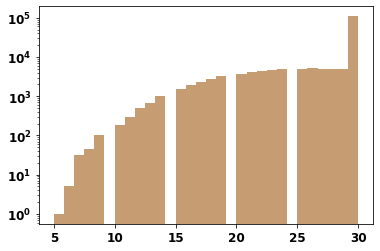

In [19]:
import datetime
import os
import sys
import time
import traceback

import pandas as pd
import pytorch_lightning as pl
import numpy as np
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import CometLogger, TensorBoardLogger
from pytorch_lightning.tuner.tuning import Tuner
from scipy import stats
from torch.nn import functional as FF
from helpers import *
from jetnet_dataloader import JetNetDataloader
from lit_nf import TransGan
from plotting import plotting

# from comet_ml import Experiment


def train(config, hyperopt=False, load_ckpt=None, i=0, root=None):

    # This function is a wrapper for the hyperparameter optimization module called ray
    # Its parameters hyperopt and load_ckpt are there for convenience
    # Config is the only relevant parameter as it sets the trainings hyperparameters
    # hyperopt:whether to optimizer hyper parameters - load_ckpt: path to checkpoint if used
    data_module = JetNetDataloader(config)  # this loads the data
    data_module.setup("training")
    model = TransGan(
        config, hyperopt, data_module.num_batches
    )  # the sets up the model,  config are hparams we want to optimize
    model.data_module = data_module
    # Callbacks to use during the training, we  checkpoint our models

    callbacks = [
        ModelCheckpoint(
            monitor="val_w1m",
            save_top_k=2,
            filename="{epoch}-{val_fpnd:.2f}-{val_w1m:.4f}-{val_w1efp:.6f}",
            dirpath=None,
            every_n_epochs=config["val_check"],
        ),
        ModelCheckpoint(
            monitor="val_fpnd",
            save_top_k=2,
            filename="{epoch}-{val_fpnd:.2f}-{val_w1m:.4f}-{val_w1efp:.6f}",
            dirpath=None,
            every_n_epochs=config["val_check"],
        )
    ]

    if False:  # load_ckpt:
        model = TransGan.load_from_checkpoint(
            "/beegfs/desy/user/kaechben/Transflow_reloaded2/2022_08_08-18_02-08/epoch=239-val_logprob=0.47-val_w1m=0.0014.ckpt"
        )
        model.data_module = data_module

    # pl.seed_everything(model.config["seed"], workers=True)
    # model.config["freq"]=20
    # model.config["lr_g"]=0.00001
    # model.config["lr_d"]=0.00001
    # model.config = config #config are our hyperparams, we make this a class property now
    logger = TensorBoardLogger(root)
    # log every n steps could be important as it decides how often it should log to tensorboard
    # Also check val every n epochs, as validation checking takes some time

    trainer = pl.Trainer(
        gpus=1,
        logger=logger,
        log_every_n_steps=100,  # auto_scale_batch_size="binsearch",
        max_epochs=config["max_epochs"],
        callbacks=callbacks,
        progress_bar_refresh_rate=int(not False) * 10,
        check_val_every_n_epoch=config["val_check"],
        num_sanity_val_steps=1,  # gradient_clip_val=.02, 
        fast_dev_run=False,
        default_root_dir=root,
    )
    # This calls the fit function which trains the model

    trainer.fit(model, datamodule=data_module)


if __name__ == "__main__":

    hyperopt = True  # This sets to run a hyperparameter optimization with ray or just running the training once

    # config = {
    #     "autoreg": False,
    #     "context_features": 0,
    #     "network_layers": 3,  # sets amount hidden layers in transformation networks -scannable
    #     "network_layers_nf": 2,  # sets amount hidden layers in transformation networks -scannable
    #     "network_nodes_nf": 256,  # amount nodes in hidden layers in transformation networks -scannable
    #     "batch_size": 2000,  # sets batch size -scannable #best one 4000
    #     "coupling_layers": 15,  # amount of invertible transformations to use -scannable
    #     "lr": 0.001,  # sets learning rate -scannable
    #     "batchnorm": False,  # use batchnorm or not -scannable
    #     "bins": 5,  # amount of bins to use in rational quadratic splines -scannable
    #     "tail_bound": 6,  # splines:max value that is transformed, over this value theree is id  -scannable
    #     "limit": 150000,  # how many data points to use, test_set is 10% of this -scannable in a sense use 10 k for faster training
    #     "n_dim": 3,  # how many dimensions to use or equivalently /3 gives the amount of particles to use NEVER EVER CHANGE THIS
    #     "dropout": 0.2,  # use droput proportion, for 0 there is no dropout -scannable
    #     "canonical": False,  # transform data coordinates to px,py,pz -scannable
    #     "max_steps": 100000,  # how many steps to use at max - lower for quicker training
    #     "lambda": 100,  # balance between massloss and nll -scannable
    #     "name": "Transflow_best",  # name for logging folder
    #     "disc": False,  # whether to train gan style discriminator that decides whether point is simulated or generated-semi-scannable
    #     "variable": 1,  # use variable amount of particles otherwise only use 30, options are true or False
    #     "parton": "t",  # choose the dataset you want to train options: t for top,q for quark,g for gluon
    #     "wgan": False,
    #     "corr": True,
    #     "num_layers": 5,
    #     "freq": 10,
    #     "n_part": 30,
    #     "fc": False,
    #     "hidden": 80,
    #     "heads": 3,
    #     "l_dim": 63,
    #     "lr_g": 1e-4,
    #     "lr_d": 1e-4,
    #     "lr_nf": 0.000722,
    #     "sched": "cosine2",
    #     "opt": "SGD",
    #     "lambda": 1,
    #     "max_epochs": 1600,
    #     "mass": True,
    #     "no_hidden": True,
    #     "clf": True,
    #     "val_check": 50,
    #     "frac_pretrain": 80,
    # }
    cols = [
        "name",
        "parton",
        "mass",
        "sched",
        "opt",
        "no_hidden",
        "clf",
        "batch_size",
        "freq",
        "seed",
        "lr_g",
        "heads",
        "hidden",
        "l_dim",
        "num_layers",
        "val_check",
    ]
    config = {
        "context_features": 1,
        "network_layers_nf": 2,
        "network_nodes_nf": 256,
        "batch_size": 1024,#1024 best
        "coupling_layers": 15,
        "lr": 0.001,
        "batchnorm": True,
        "bins": 5,
        "tail_bound": 6,
        "limit": 200000,
        "n_dim": 3,
        "dropout": 0.2,
        "canonical": False,
        "max_steps": 100000,
        "lambda": 100,
        "name": "Transflow_notebook",
        "disc": False,
        "parton": "q",
        "wgan": False,
        "num_layers": 4,
        "freq": 6,
        "n_part": 30,
        "fc": False,
        "hidden": 500,
        "heads": 6,
        "l_dim": 25,
        "lr_g": 0.0004327405312571664,
        "lr_d": 0.0004327405312571664,
        "lr_nf": 0.000722,
        "sched": "cosine",
        "opt": "Adam",
        "max_epochs": 800,
        "mass": True,
        "no_hidden": False,
        "clf": True,
        "val_check": 5,
        "frac_pretrain": 40,
        "seed": 69,
        "quantile": True,
    }  #'seed': 744,sched:"None","wgan":False,"freq":8,"sched":None,"heads":4
    config["frac_pretrain"]=config["max_epochs"]//40
    config["l_dim"] = config["l_dim"] * config["heads"]

    print(config["name"])
    if not hyperopt:
        hyperopt = True
        for col in cols:
            print('"' + col + '":' + str(config[col]))
        print("NOT HYPEROPT")
        root = "/beegfs/desy/user/" + os.environ["USER"] + "/"+config["parton"]+"_" + config["name"]
        train(config, hyperopt=hyperopt, root=root)
    else:

        num_samples = 1  # how many hparam settings to sample with ray
        resources = {"cpu": 10, "gpu": 0.5}       
        for i in range(num_samples):
            
            config["sched"] = np.random.choice(["cosine", "cosine2", None])
            config["opt"] = np.random.choice(["Adam", "AdamW"])#True, 
            config["mass"] = True#np.random.choice([True, False])
            # config["quantile"] = np.random.choice([True, False])
            config["wgan"] = False#np.random.choice([True, False])#

            config["no_hidden"] = True# np.random.choice([True, False,])
            # config["clf"] = np.random.choice([True, False])
            config["batch_size"] = 2 ** np.random.randint(8, 12)
            config["freq"] = 1# np.random.choice([1,3,7])
            config["seed"] = int(np.random.randint(1, 1000))
            config["lr_g"] = stats.loguniform.rvs(0.0001, 0.001, size=1)[0]
            config["lr_nf"] = stats.loguniform.rvs(0.00001, 0.001, size=1)[0]
            config["heads"] = np.random.randint(3, 8)
            config["l_dim"] = config["heads"] * np.random.randint(10, 30)
            # config["hidden"] = 100 * np.random.randint(2, 7)
            config["num_layers"] = np.random.randint(3, 8)
            config["parton"]=np.random.choice(["t","q","g"])
            config["parton"] = "q"
            config["norm"] = False#np.random.choice([True,False])
            config["name"] = config["name"] + "_" + config["parton"]
            print(config["parton"])
            
            if len(sys.argv) > 2:
                root = "/beegfs/desy/user/"+ os.environ["USER"]+"/"+config["name"]+"/run"+sys.argv[1]+"_"+str(sys.argv[2])
                print(root)
            else:
                root = "/beegfs/desy/user/" + os.environ["USER"] + "/"+config["name"]
            for col in cols:
                print('"' + col + '":' + str(config[col]))
            if config["parton"]=="q":
                config["network_layers_nf"]=2
                config["network_nodes_nf"]=128
                config["tail_bound"]=6
                config["lr_nf"]=0.00047352
                config["quantile"]=True
            if config["parton"]=="t":
                config["network_layers_nf"]=2
                config["network_nodes_nf"]=128
                config["tail_bound"]=6
                config["lr_nf"]=0.00067486
            try:
                train(config, hyperopt=hyperopt, i=i, root=root)
            except:
                print("error")
                traceback.print_exc()


Transflow_notebook
q
/beegfs/desy/user/kaechben/Transflow_notebook_q/run-f_/home/kaechben/.local/share/jupyter/runtime/kernel-3ca456e3-5ac0-4bd4-9bf8-e403ec271d33.json
"name":Transflow_notebook_q
"parton":q
"mass":True
"sched":cosine2
"opt":Adam
"no_hidden":True
"clf":True
"batch_size":512
"freq":1
"seed":144
"lr_g":0.00014765438968645167
"heads":5
"hidden":500
"l_dim":50
"num_layers":6
"val_check":5


/beegfs/desy/user/kaechben/.conda/envs/jetnet/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:96: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=10)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /beegfs/desy/user/kaechben/Transflow_notebook_q/run-f_/home/kaechben/.local/share/jupyter/runtime/kernel-3ca456e3-5ac0-4bd4-9bf8-e403ec271d33.json/lightning_logs
/beegfs/desy/user/kaechben/.conda/envs/jetnet/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:724: UserWarning: Detected KeyboardInterrup

tensor(0.)


(array([ 183., 1184., 1532., 1524., 1686., 1920., 2243., 2709., 3108.,
        3266., 3963., 3947., 3839., 3409., 3170., 2688., 2434., 2058.,
        1664., 1237.,  943.,  726.,  566.,  404.,  295.,  238.,  155.,
          66.,   38.,    9.]),
 array([-0.0195159 ,  0.01502087,  0.04955763,  0.08409441,  0.11863117,
         0.15316793,  0.18770471,  0.22224148,  0.25677824,  0.29131502,
         0.32585177,  0.36038855,  0.39492533,  0.42946208,  0.46399885,
         0.49853563,  0.5330724 ,  0.56760913,  0.6021459 ,  0.6366827 ,
         0.67121947,  0.70575625,  0.74029297,  0.77482975,  0.8093665 ,
         0.8439033 ,  0.8784401 ,  0.91297686,  0.9475136 ,  0.98205036,
         1.0165871 ], dtype=float32),
 <BarContainer object of 30 artists>)

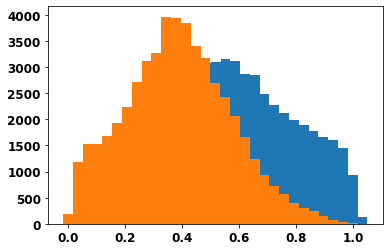

In [65]:
plt.hist(pred_real.detach().numpy(),bins=30)
plt.hist(pred_fake.detach().numpy(),bins=30)


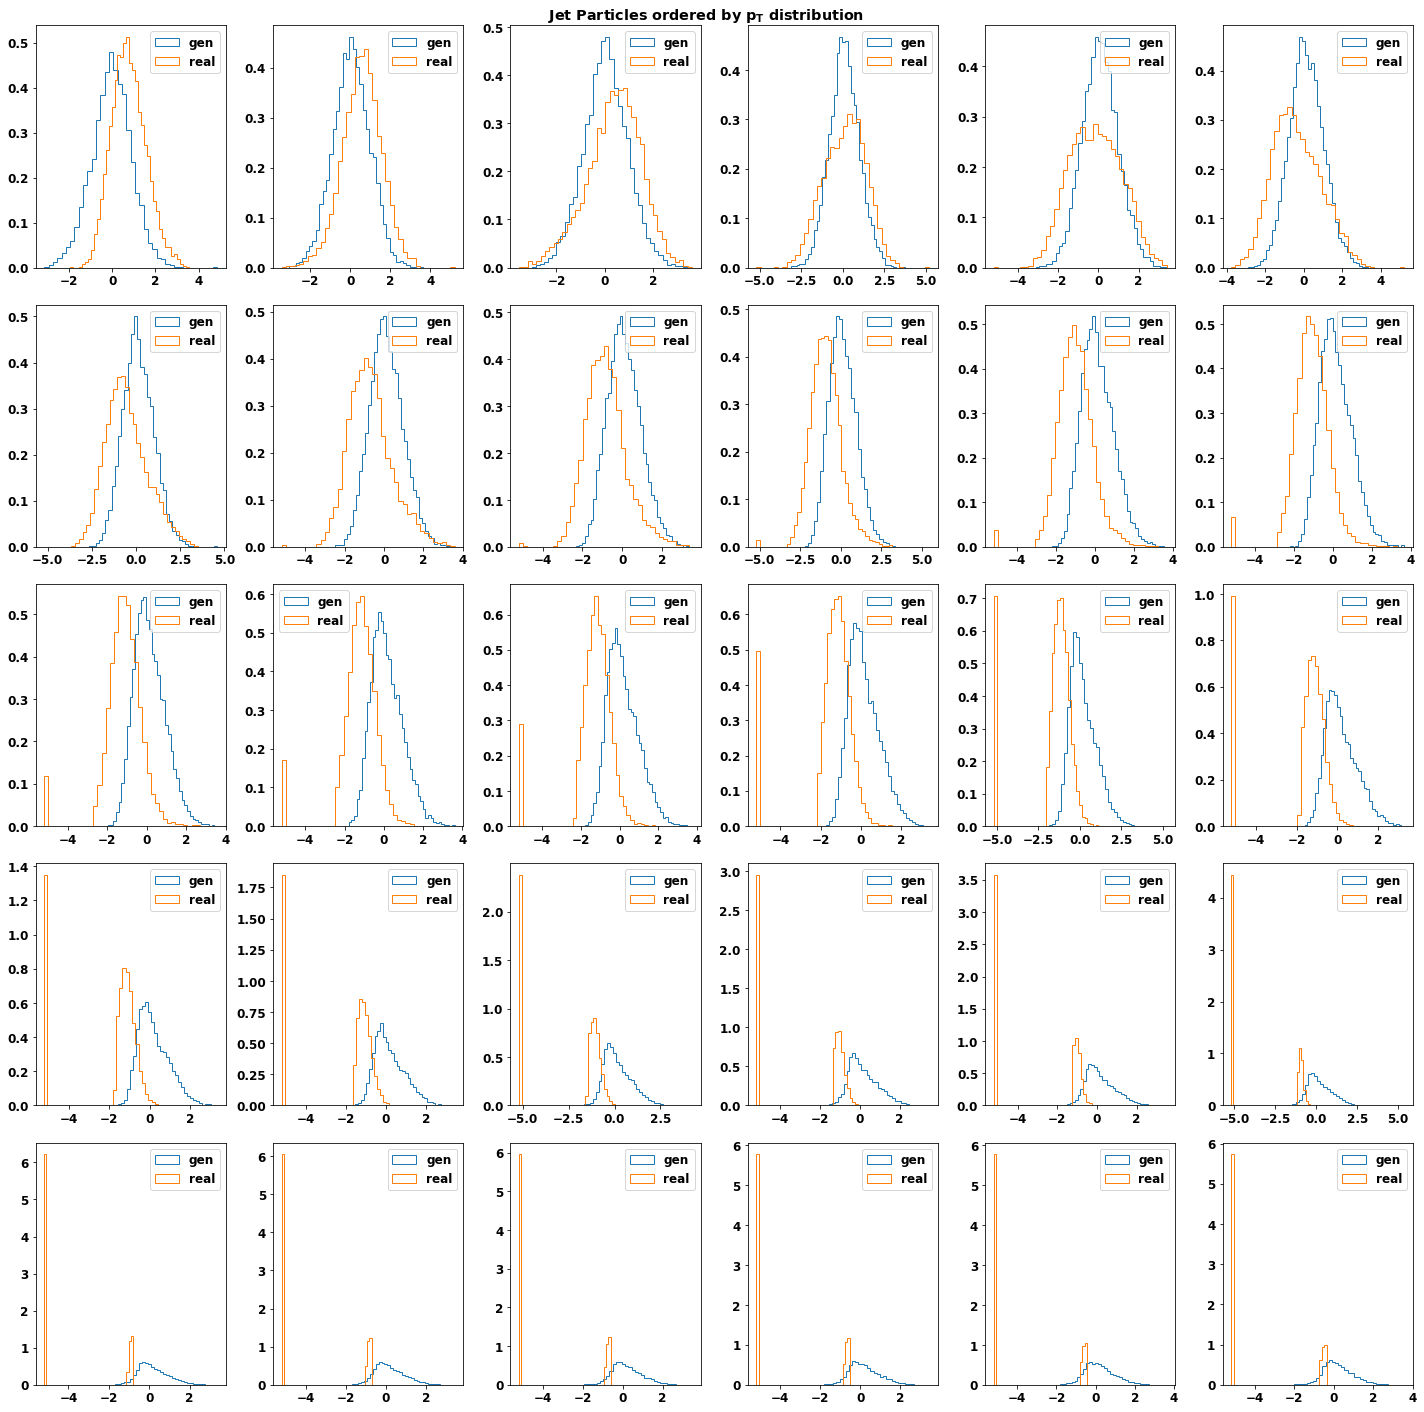

(array([3.083e+03, 5.000e+00, 2.800e+01, 2.330e+02, 9.210e+02, 6.600e+01,
        1.141e+03, 1.140e+02, 1.242e+03, 1.400e+01, 1.800e+02, 0.000e+00,
        6.570e+02, 1.800e+01, 0.000e+00, 2.190e+02, 1.000e+00, 1.590e+02,
        0.000e+00, 1.400e+01, 0.000e+00, 4.100e+01, 1.000e+00, 0.000e+00,
        1.700e+01, 0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 4.000e+00]),
 array([0.        , 0.00180422, 0.00360844, 0.00541266, 0.00721688,
        0.0090211 , 0.01082532, 0.01262954, 0.01443376, 0.01623798,
        0.0180422 , 0.01984642, 0.02165063, 0.02345485, 0.02525907,
        0.02706329, 0.02886751, 0.03067173, 0.03247595, 0.03428017,
        0.03608439, 0.03788861, 0.03969283, 0.04149705, 0.04330127,
        0.04510549, 0.04690971, 0.04871393, 0.05051815, 0.05232237,
        0.05412659], dtype=float32),
 <BarContainer object of 30 artists>)

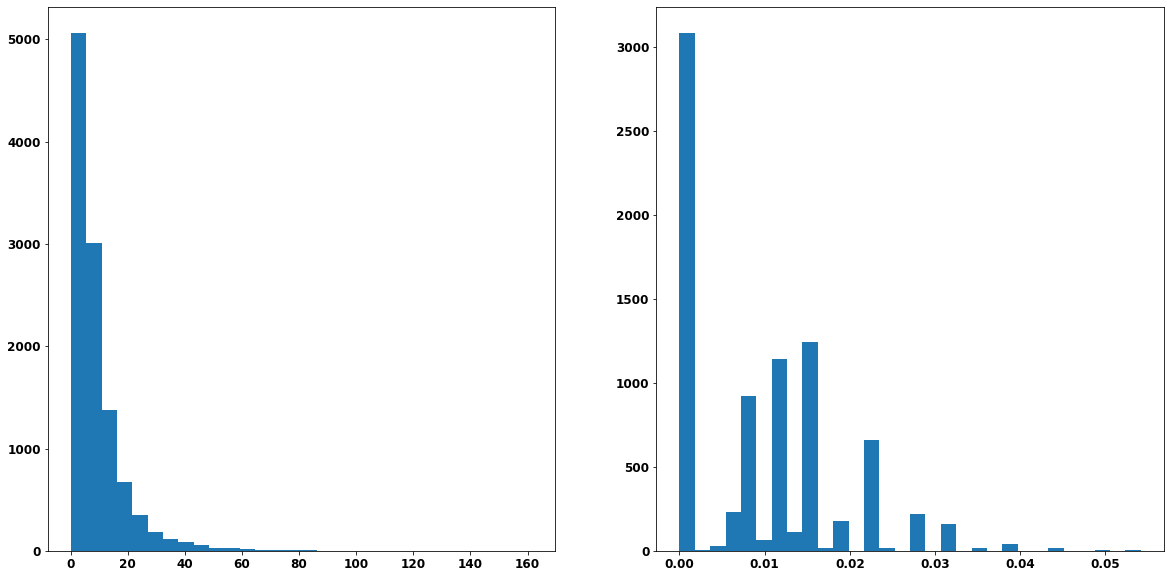

In [66]:
# corrs=model.gen_net(z,mask_test)
fig,ax=plt.subplots(5,6,figsize=(20,20))
t=gen.reshape(-1,30,3)
q=batch.reshape(-1,30,3)
k=2
n=mask.sum(axis=1)
n_test=mask_test.sum(axis=1)

mt=mask_test[n_test>5]
m=mask[n>5]

q=q[n>5,:,:]
t=t[n_test>5,:,:]

for i in range(30):
    _,bins,_=ax[i//6,i%6].hist(t[:,i,k].numpy(),bins=40,label="gen",histtype="step",density=1)
    ax[i//6,i%6].hist(q[:,i,k].numpy(),bins=40,label="real",histtype="step",density=1)
#     ax[i//6,i%6].hist(g[:,i,2].numpy(),bins=bins,label="g",histtype="step")
    ax[i//6,i%6].legend()
plt.suptitle(r"Jet Particles ordered by $p_T$ distribution")
plt.tight_layout()
plt.show()

fig,ax=plt.subplots(ncols=2,figsize=(20,10))
ax[0].hist(mass(t,mt).numpy(),bins=30)
ax[1].hist(mass(q,m).numpy(),bins=30)

torch.Size([51204, 30])